## Train OGMM Model

In [ ]:
%load_ext autoreload
%autoreload 2

from models.gmmreg import GMMReg
from train import *
from configs.cfgs import get_parser
from datasets.dataloader import data_loader
from datasets.modelnet import *

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

args = get_parser().parse_args([
    '--root', '~/Desktop/data/',
    # '--batch_size', '48', '--lr', '1e-4', '--num_workers', '8',
    '--batch_size', '4', '--lr', '1e-3', '--num_workers', '2',
    '--epochs', '50',
    '--exp_name', 'lr_1e-4'
])
optim_path = os.path.join(args.model_path, f'checkpoints/{args.exp_name}/models/optim_model.pt')


'''Init model'''
model = GMMReg(args.emb_dims, args.n_clusters, args).cuda()
model.load_state_dict(torch.load(optim_path))

train_loader, test_loader = data_loader(args)
item_train = next(iter(train_loader))   # (B=4,N,C=3)
# item_test = next(iter(test_loader))

def forward_one_batch(model, data):
    ''' Feed one batch of data into model and return the output 
        Code based on train.eval_one_batch()
    '''
    #TODO: How to make N for src, tgt match. Preprocessing???
    pts1 = data["src_xyz"].cuda().transpose(-1, -2)       # (B,N,C=3) -> (B,3,N)
    pts2 = data["tgt_xyz"].cuda().transpose(-1, -2)       # (B,N,C=3) -> (B,3,N)  
    src_overlap = data["src_overlap"].cuda().squeeze(-1)  # (B, N)
    tgt_overlap = data["tgt_overlap"].cuda().squeeze(-1)  # (B, N)
    transf_gt = data["transform_gt"].cuda()
    rot_gt, trans_gt = decompose_trans(transf_gt)         # (B,3,3), (B,3,1) 
    # trans_gt = trans_gt.view(trans_gt.shape[0], 3)
    rot, trans, src_o, tgt_o, clu_loss = model(pts1, pts2, True)
    
    
forward_one_batch(model, item_train)

# plt_pcds([item['src_xyz'], item['tgt_xyz'],item['tgt_raw']])

Data item contains following keys:
```
- src_xyz:      (N=717,3)
- tgt_xyz:      (N=717,3)
- tgt_raw:      (1024, 3)
- src_overlap:  (N=717,)
- tgt_overlap:  (N=717,)
- transform_gt: (3,4)       rotation and translation SE(3) pose
- pose_gt:      (7,)        quaternion (4,) ⊕ translation (3,) from transform_gt
- idx
```



## Test OGMM and DeepGMR Model

### Test on toy data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/kyle/Desktop/ogmm/gmm_reg.py:427: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 1], marker='x', alpha=1, edgecolors='none', label='mu')


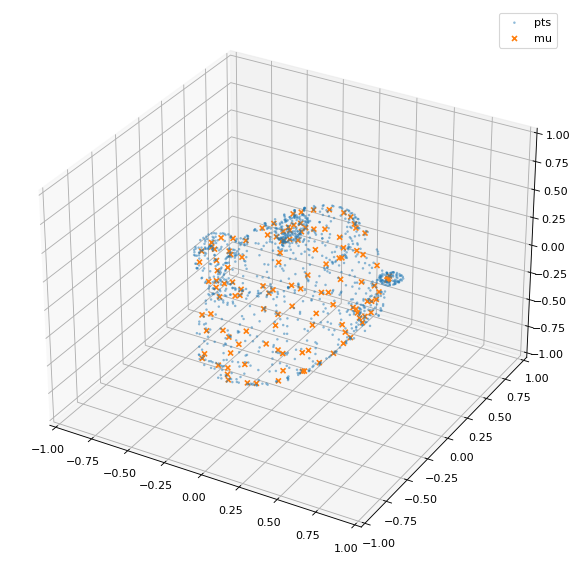

<Figure size 640x480 with 0 Axes>

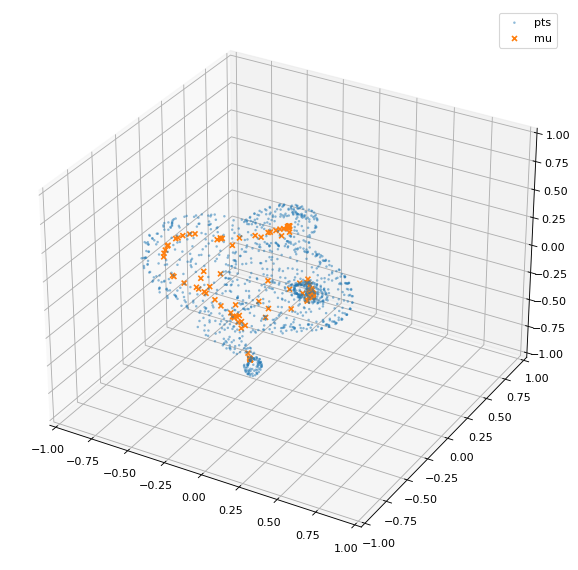

predicted translation: [-0.85790944 -1.2069376   1.2167863 ]


<Figure size 640x480 with 0 Axes>

In [11]:
%load_ext autoreload
%autoreload 2
import pickle
from models.gmmreg import GMMReg
from train import *
from configs.cfgs import get_parser
from datasets.modelnet import *
from gmm_reg import *
from os.path import expanduser


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


def my_gmm_registration(pts1, pts2, model=None, optim_path=None):
    ''' Perform GMM registration without learnable model 
    Input:
        - pts1: (N,3) numpy array
        - pts2: (N,3) numpy array
        - model: (optional) GMMReg model
    '''
    if model is None or optim_path is None:
        pts1 = numpy_to_torch(pts1).unsqueeze(0)
        pts2 = numpy_to_torch(pts2).unsqueeze(0)

        gamma1, pi1, mu1 = wkmeans(pts1)
        pi1, mu1, sig1 = gmm_params(gamma1, pts1, return_sigma=True)
        gamma2, pi2, mu2 = wkmeans(pts2)
        pi2, mu2, sig2 = gmm_params(gamma2, pts2, return_sigma=True)

        T_pred = gmm_register(pi1, mu1, mu2, sig2).squeeze(0)
        r_pred, t_pred = T_pred[:3,:3], T_pred[:3,3]

        pts1 = torch_to_numpy(pts1).squeeze()
        pts2 = torch_to_numpy(pts2).squeeze()
        r_pred = torch_to_numpy(r_pred)
        t_pred = torch_to_numpy(t_pred)

        mu1 = torch_to_numpy(mu1).squeeze()
        mu2 = torch_to_numpy(mu2).squeeze()

        plt_gmm(pts1, mu1)
        plt_gmm(pts2, mu2)
    
    else:
        model.load_state_dict(torch.load(optim_path))
        pts1 = numpy_to_torch(pts1).unsqueeze(0).transpose(-1,-2)
        pts2 = numpy_to_torch(pts2).unsqueeze(0).transpose(-1,-2)
        r_pred, t_pred, src_o, tgt_o, loss = model(pts1, pts2, False)
        r_pred, t_pred = torch_to_numpy(r_pred.squeeze(0)), torch_to_numpy(t_pred.squeeze(0))
    
    return r_pred, t_pred

args = get_parser().parse_args([])
optim_path = os.path.join(args.model_path, f'checkpoints/{args.exp_name}/models/optim_model.pt')

# pcd = pickle.load(open(expanduser("~/Desktop/data/pcd_toys/banana.pickle"), 'rb'))  # (N,3)
pcd = pickle.load(open(expanduser("~/Desktop/data/pcd_toys/teapot.pickle"), 'rb'))  # (N,3)
pcd = pcd[::3,:] / 3
T = get_rand_transform() 
r, t = T[:3,:3], T[3,:3] *2
pts1, pts2 = pcd, apply_transform(pcd, r, t)

model = GMMReg(args.emb_dims, args.n_clusters, args).cuda()
r_pred1, t_pred1 = my_gmm_registration(pts1, pts2, model, optim_path)
r_pred2, t_pred2 = my_gmm_registration(pts1, pts2)

print(f'predicted translation: {t_pred2}')
# compare_pcd([apply_transform(pts1, r_pred1, t_pred1), pts2], title="Predicted pose alignment (w/ trained GMMReg Model)")
# compare_pcd([apply_transform(pts1, r_pred2, t_pred2), pts2], title="Predicted pose alignment (no trained model)")
# compare_pcd([apply_transform(pts1, r, t), pts2], title="Ground truth pose alignment")


# TODO: Can we train model to perform well on teapot?

# print(r_pred.shape, t_pred.shape, pts1.shape)


### Pre-trained model performance on **test data**

torch.Size([24, 3, 3]) torch.Size([24, 3, 1]) torch.Size([24, 3, 3]) torch.Size([24, 3]) torch.Size([24, 3, 717]) torch.Size([24, 3, 717])


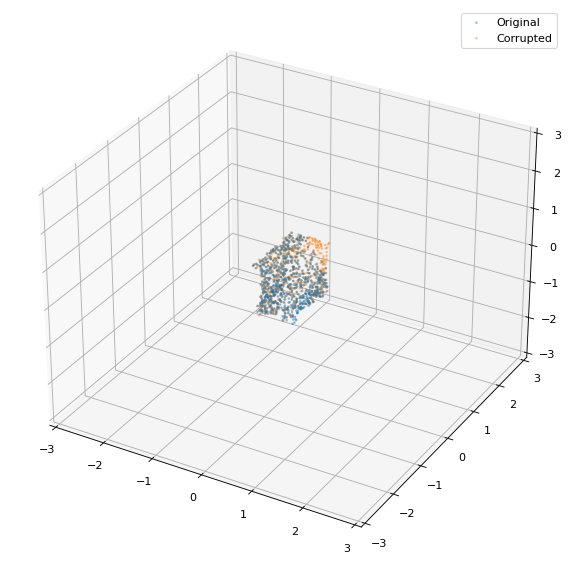

<Figure size 640x480 with 0 Axes>

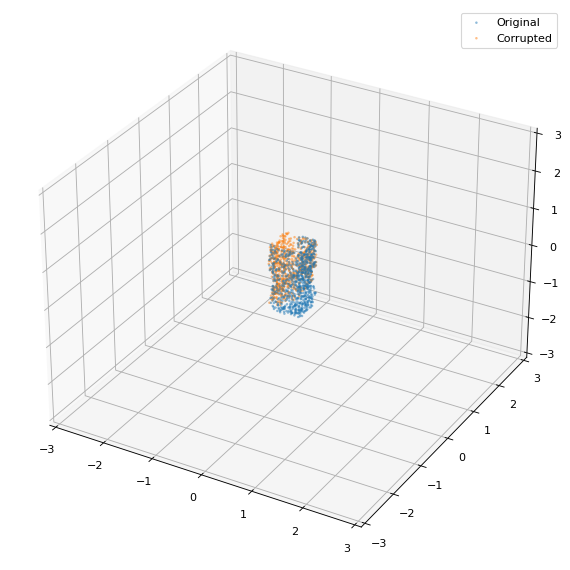

<Figure size 640x480 with 0 Axes>

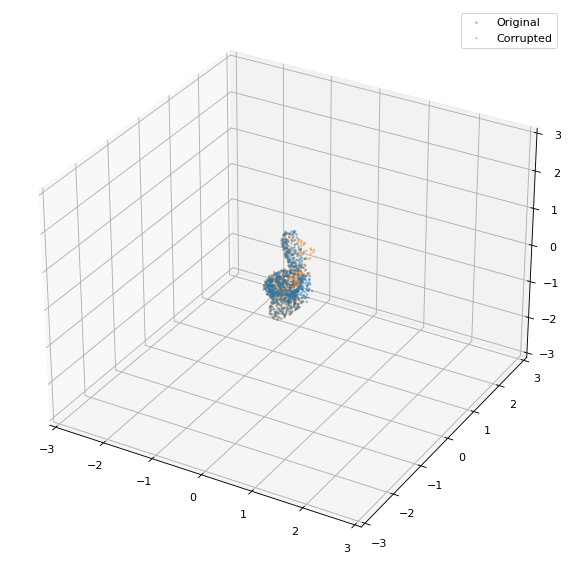

<Figure size 640x480 with 0 Axes>

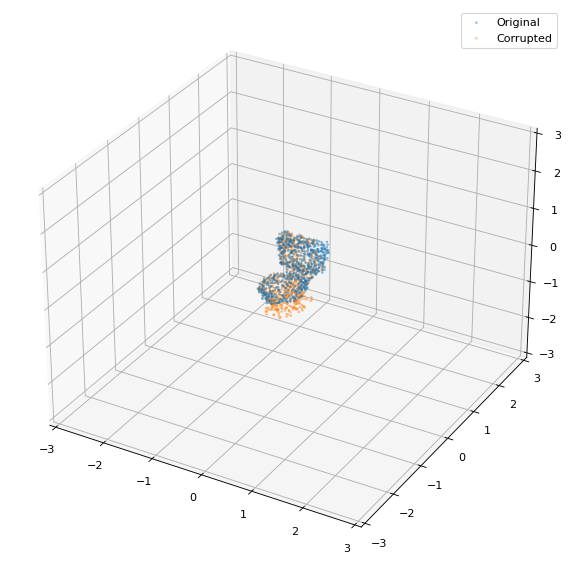

<Figure size 640x480 with 0 Axes>

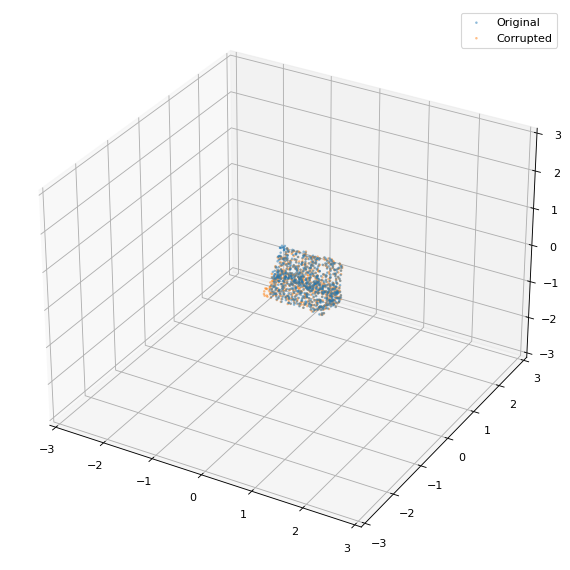

<Figure size 640x480 with 0 Axes>

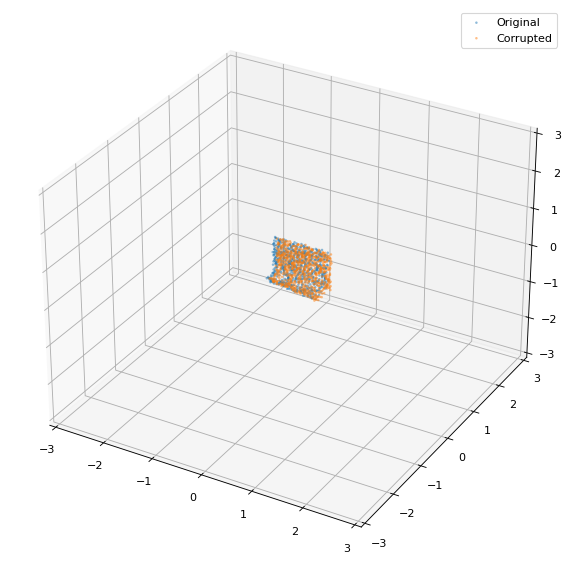

<Figure size 640x480 with 0 Axes>

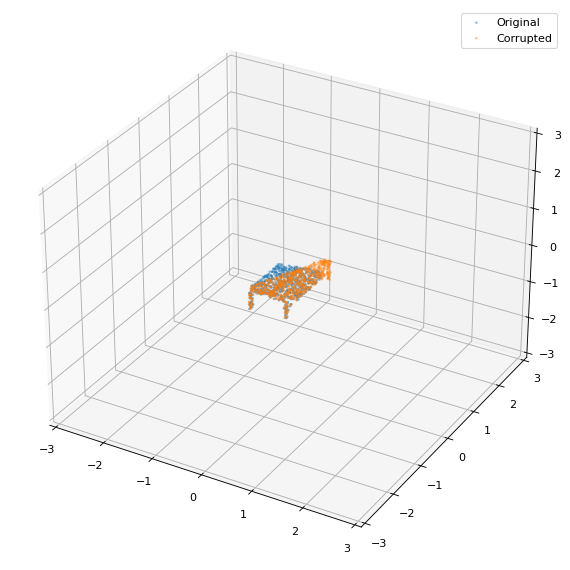

<Figure size 640x480 with 0 Axes>

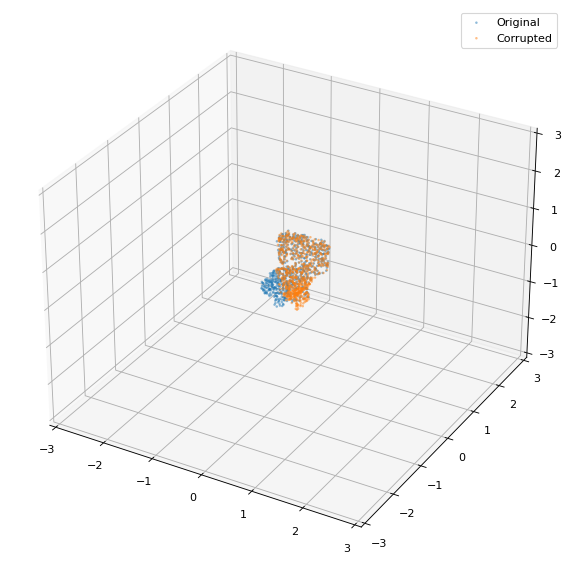

<Figure size 640x480 with 0 Axes>

In [18]:
from models.gmmreg import GMMReg
from datasets.dataloader import data_loader
from train import *
from configs.cfgs import get_parser
from datasets.modelnet import *
from gmm_reg import *
from datasets.datautils import *
from datasets.transforms import *

args = get_parser().parse_args([
    '--root', '~/Desktop/data/',
    '--batch_size', '16',
    '--epochs', '50',
    '--lr', '1e-4',
    '--exp_name', 'lr_1e-4'
])
optim_path = os.path.join(args.model_path, f'checkpoints/{args.exp_name}/models/optim_model.pt')


def forward_one_batch(model, data):
    ''' Feed one batch of data into model and return the output 
        Code based on train.eval_one_batch()
    '''
    #TODO: How to make N for src, tgt match. Preprocessing???
    pts1 = data["src_xyz"].cuda().transpose(-1, -2)       # (B,N,C=3) -> (B,3,N)
    pts2 = data["tgt_xyz"].cuda().transpose(-1, -2)       # (B,N,C=3) -> (B,3,N)  
    src_overlap = data["src_overlap"].cuda().squeeze(-1)  # (B, N)
    tgt_overlap = data["tgt_overlap"].cuda().squeeze(-1)  # (B, N)
    transf_gt = data["transform_gt"].cuda()
    rot_gt, trans_gt = decompose_trans(transf_gt)         # (B,3,3), (B,3,1) 
    rot, trans, src_o, tgt_o, clu_loss = model(pts1, pts2, True)

    # pose_gt = torch.concat([rot_gt, trans_gt], dim=-1)  # (B,3,4)
    # transformed = torch.einsum('...ij,...bj->...bi', rot_gt, pts1) + trans_gt.transpose(-1, -2)  # Rx + t
    print(
        rot_gt.shape, trans_gt.shape,   # (B,3,3), (B,3,1)
        rot.shape, trans.shape,          # (B,3,3), (B,3)
        pts1.shape, pts2.shape          # (B,3,N), (B,3,N)
    )
    
    ''' Appl'''
    # transformed = torch.einsum('...ij,...kj->...ki', rot_gt, pts1.transpose(-1,-2)) + trans_gt.transpose(-1, -2)   # gt transformation
    # transformed = torch.einsum('...ij,...kj->...ki', rot, pts1.transpose(-1,-2)) + trans.unsqueeze(1)   # pred transformation
    # transformed = torch.einsum('...ij,...jk->...ik', rot, pts1).transpose(-1,-2) + trans.unsqueeze(1)
    transformed = apply_transform_batch(pts1, rot, trans)
    for i in range(8):
        src = torch_to_numpy(pts2[i].transpose(-1,-2))
        tgt = torch_to_numpy(transformed[i])
        compare_pcd([src, tgt])
    

    # for i in range(8):
    #     rot_ = torch_to_numpy(rot[i].squeeze())
    #     trans_ = torch_to_numpy(trans[i].squeeze())
    #     pts1_ = torch_to_numpy(pts1[i])
    #     pts2_ = torch_to_numpy(pts2[i])

    #     print(rot_.shape, trans_.shape, pts1_.shape, pts2_.shape)

    #     rot_gt_np = torch_to_numpy(rot_gt[i].squeeze())
    #     trans_gt_np = torch_to_numpy(trans_gt[i].squeeze())
    #     compare_pcd([apply_transform(pts1_, rot_, trans_), pts2_.T], title=f"pts1 {pts1_.shape} vs. pts2 {pts2_.shape}", path=f'{i}.png')

    return rot, trans, src_o, tgt_o, clu_loss
    
    
'''Init model'''
model = GMMReg(args.emb_dims, args.n_clusters, args).cuda()
model.load_state_dict(torch.load(optim_path))

train_loader, test_loader = data_loader(args)
data = next(iter(test_loader))
rot, trans, src_o, tgt_o, clu_loss = forward_one_batch(model, data)

### Try overfitting a toy point cloud

In [7]:
import pickle
from models.gmmreg import GMMReg
from train import *
from configs.cfgs import get_parser
from datasets.modelnet import *
from gmm_reg import *
from os.path import expanduser

args = get_parser().parse_args([
    '--root', '~/Desktop/data/',
    '--batch_size', '16',
    '--epochs', '50',
    '--lr', '1e-4',
    '--exp_name', 'lr_1e-4'
])
optim_path = os.path.join(args.model_path, f'checkpoints/{args.exp_name}/models/optim_model.pt')

pcd = pickle.load(open(expanduser("~/Desktop/data/pcd_toys/teapot.pickle"), 'rb'))  # (N,3)
T = get_rand_transform() 
r_gt, t_gt = T[:3,:3], T[3,:3]
pts1, pts2 = pcd, apply_transform(pcd, r_gt, t_gt)

pts1 = numpy_to_torch(pts1).unsqueeze(0).transpose(-1,-2)
pts2 = numpy_to_torch(pts2).unsqueeze(0).transpose(-1,-2)
r_gt = numpy_to_torch(r_gt).unsqueeze(0)
t_gt = numpy_to_torch(t_gt).unsqueeze(0)

print(
    pts1.shape, pts2.shape, r_gt.shape, t_gt.shape
)



def train_toy_example(model, pts1, pts2, r_gt, t_gt, epoch=1):
    src_overlap = torch.ones_like(pts1)


    ''' Train toy example '''
    for _ in tqdm(range(epoch)):
        r_pred, t_pred, src_o, tgt_o, loss = model(pts1, pts2, False)

    return r_pred, t_pred

model = GMMReg(args.emb_dims, args.n_clusters, args).cuda()
model.load_state_dict(torch.load(optim_path))
train_toy_example(model,pts1,pts2,r_gt,t_gt)

def forward_one_batch(model, data):
    ''' Feed one batch of data into model and return the output 
        Code based on train.eval_one_batch()
    '''
    #TODO: How to make N for src, tgt match. Preprocessing???
    pts1 = data["src_xyz"].cuda().transpose(-1, -2)       # (B,N,C=3) -> (B,3,N)
    pts2 = data["tgt_xyz"].cuda().transpose(-1, -2)       # (B,N,C=3) -> (B,3,N)  
    src_overlap = data["src_overlap"].cuda().squeeze(-1)  # (B, N)
    tgt_overlap = data["tgt_overlap"].cuda().squeeze(-1)  # (B, N)
    transf_gt = data["transform_gt"].cuda()
    rot_gt, trans_gt = decompose_trans(transf_gt)         # (B,3,3), (B,3,1) 
    rot, trans, src_o, tgt_o, clu_loss = model(pts1, pts2, True)

    # pose_gt = torch.concat([rot_gt, trans_gt], dim=-1)  # (B,3,4)
    # transformed = torch.einsum('...ij,...bj->...bi', rot_gt, pts1) + trans_gt.transpose(-1, -2)  # Rx + t
    print(
        rot_gt.shape, trans_gt.shape,   # (B,3,3), (B,3,1)
        rot.shape, trans.shape,          # (B,3,3), (B,3)
        pts1.shape, pts2.shape          # (B,3,N), (B,3,N)
    )
    
    ''' Appl'''
    # transformed = torch.einsum('...ij,...kj->...ki', rot_gt, pts1.transpose(-1,-2)) + trans_gt.transpose(-1, -2)   # gt transformation
    # transformed = torch.einsum('...ij,...kj->...ki', rot, pts1.transpose(-1,-2)) + trans.unsqueeze(1)   # pred transformation
    # transformed = torch.einsum('...ij,...jk->...ik', rot, pts1).transpose(-1,-2) + trans.unsqueeze(1)
    transformed = apply_transform_batch(pts1, rot, trans)
    for i in range(8):
        src = torch_to_numpy(pts2[i].transpose(-1,-2))
        tgt = torch_to_numpy(transformed[i])
        compare_pcd([src, tgt])
    

    # for i in range(8):
    #     rot_ = torch_to_numpy(rot[i].squeeze())
    #     trans_ = torch_to_numpy(trans[i].squeeze())
    #     pts1_ = torch_to_numpy(pts1[i])
    #     pts2_ = torch_to_numpy(pts2[i])

    #     print(rot_.shape, trans_.shape, pts1_.shape, pts2_.shape)

    #     rot_gt_np = torch_to_numpy(rot_gt[i].squeeze())
    #     trans_gt_np = torch_to_numpy(trans_gt[i].squeeze())
    #     compare_pcd([apply_transform(pts1_, rot_, trans_), pts2_.T], title=f"pts1 {pts1_.shape} vs. pts2 {pts2_.shape}", path=f'{i}.png')

    return rot, trans, src_o, tgt_o, clu_loss
    
    



# train_loader, test_loader = data_loader(args)
# data = next(iter(test_loader))
# rot, trans, src_o, tgt_o, clu_loss = forward_one_batch(model, data)

torch.Size([1, 3, 3241]) torch.Size([1, 3, 3241]) torch.Size([1, 3, 3]) torch.Size([1, 3])


## Test PyCPD
[PyCPD Documentation](https://siavashk.github.io/pycpd/deformable_registration.html)

<class 'numpy.ndarray'> (3241, 3) (3, 3) (3,)


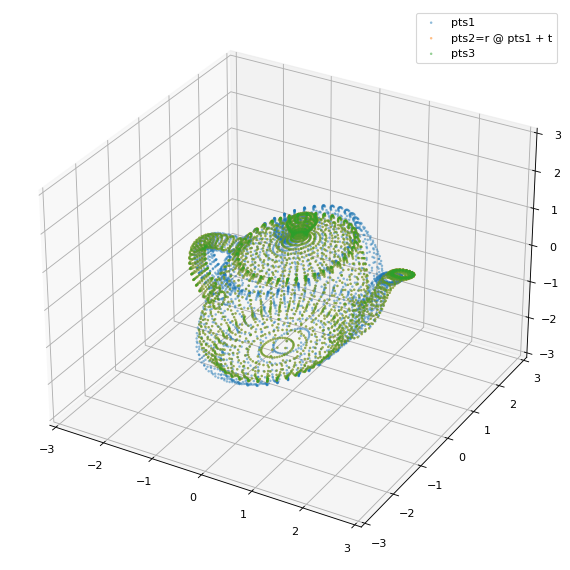

<Figure size 640x480 with 0 Axes>

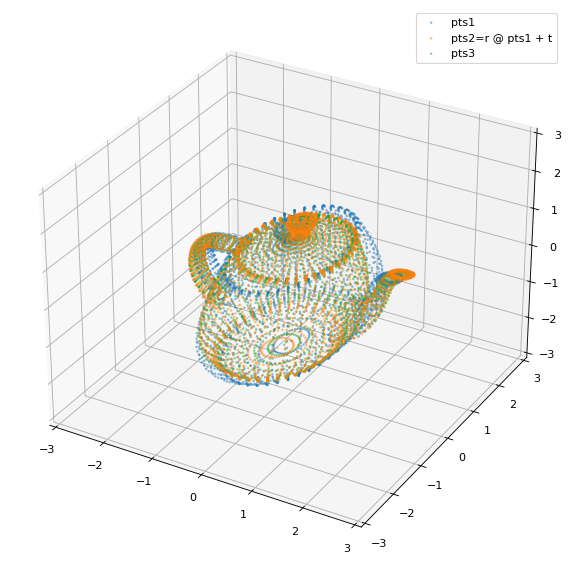

<Figure size 640x480 with 0 Axes>

In [7]:
from pycpd.deformable_registration import DeformableRegistration
from gmm_reg import *
import pickle
from os.path import expanduser

import trimesh

pcd = pickle.load(open(expanduser("~/Desktop/data/pcd_toys/teapot.pickle"), 'rb')) 
pcd = np.array(pcd.data)


r_gt = np.array([[ 0.989,  0.043, -0.138],[-0.070,  0.977, -0.200],[ 0.126,  0.207,  0.969]])
t_gt = np.zeros(3)


pts1, pts2 = pcd, apply_transform(pcd, r_gt, t_gt)

print(
    type(pts1), pts2.shape, r_gt.shape, t_gt.shape
)


compare_pcd([pts1, pts2, (r_gt@pts1.T).T])

reg_solver = DeformableRegistration(X=pts2, Y=pts1) # X = target, Y = source
reg_solver.register()

pts1T= reg_solver.transform_point_cloud(pts1)
compare_pcd([pts1, pts2, pts1T])

## TODOs

1. Visualize GMM centroids to see how `gmm_params()` work.
2. Reduce rotation magnitude. See how `gmm_register()` work then.